# VQA Model v1 by Rafael Garcia, Pau Gil, Bernat Joseph, Jordi Suñer

#Initializations

## Imports & Models (NO Interaction Required)

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import io
import torch
import torch.nn as nn # Jordi
import torch.nn.functional as F #Jordi
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import json
import pprint
import numpy as np
import torch.optim as optim
import tensorflow_hub as hub

# https://tfhub.dev/google/universal-sentence-encoder/4
device = torch.device("cuda")
sentence_embedding_generator = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## Mount Gdrive (Interaction Required)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset

## Dataset Initialization
First we create a Dataset based on the content of the folder (train = False -> Validation Dataset)





In [ ]:
"""
     Data structure:

     root_dir
        |_ mscoco_qtrain.txt [list of question IDs for training]
        |_ mscoco_qtest.txt  [list of question IDs for testing]
        |_ mscoco_q.json     [json of questions]
        |_ mscoco_a.json     [json of annotations]
        |_ coco              [subdirectory for images]
            |_ image 1
            |_ image 2
              ...
            |_ image n

"""

class TestDataset(Dataset):
    def __init__(self, root_dir, train=False, transform=None):
        """
        Args:
            root_dir (string): root directory for the data           
            train (bool, optional): choose training or testing datasets
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

#   Define some constants to access files

        self.image_prefix = "COCO_val2014_"
        self.image_postfix = ".jpg"
        self.image_subdir = 'coco'
        self.questions_list_train_fname = 'mscoco_qtrain.txt'
        self.questions_list_test_fname = 'mscoco_qtest.txt'
        self.questions_fname = 'mscoco_q.json'
        self.annotations_fname = 'mscoco_a.json'

#   Store parameters as class attributes

        self.root_dir = root_dir
        self.train = train
        self.transform = transform

#   Load questions json file

        fqfname = os.path.join(self.root_dir, self.questions_fname)
        self.questions = json.load(open(fqfname, 'r'))

#   Load annotations json file

        fqfname = os.path.join(self.root_dir, self.annotations_fname)
        self.annotations = json.load(open(fqfname, 'r'))

#   Depending on self.train, load either training question list or
#       testing question list

        if (self.train):
            fqfname = os.path.join(self.root_dir, self.questions_list_train_fname)
            with open(fqfname) as f:
              tmp = f.read().splitlines()
            self.questions_list = list(map(int, tmp))
        else:
            fqfname = os.path.join(self.root_dir, self.questions_list_test_fname)
            with open(fqfname) as f:
              tmp = f.read().splitlines()
            self.questions_list = list(map(int, tmp))
            #self.questions_list = self.questions_list[:250]

    def __len__(self):
        return len(self.questions_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

#   Get question_id from the list

        question_id = self.questions_list[idx]

#   Find corresponding question and annotation
#       (use next() to get a single value from the list comprehension)

        question = next(x for x in self.questions if x['question_id'] == question_id)
        annotation = next(a for a in self.annotations if a['question_id'] == question_id)

        image_id = question['image_id']
        file_name = self.image_prefix+("0"*12+str(image_id))[-12:]+self.image_postfix
        fqfname = os.path.join(self.root_dir,self.image_subdir,file_name)
        image = mpimg.imread(fqfname)
        if image.ndim < 3:
          image = np.expand_dims(image,axis=0)
          image = np.repeat(image,3,0)  

#   Apply transformation if there is any

        if self.transform:
            image = self.transform(image)        

#   return tuple: image, question text, answer text

        return image, question['question'], annotation['multiple_choice_answer']

## Transformed Dataset based on Dataloader for RESNET 
Generates batch of images transformed to be processed by a RESNET 

In [ ]:
#root_dir = "drive/My Drive/aidl" # 750 initial images
#root_dir = "drive/My Drive/aidl/model5000_1_20" # 5000  images Sept-2nd
root_dir = "drive/My Drive/aidl/model10000_1_20" # 10000  images Oct-9th
#root_dir = "drive/My Drive/aidl/model10000_yes_no" # 10000  images Oct-9th

batch_size = 25 #10 #5

t = transforms.Compose([
    transforms.ToPILImage(), # Required for Visualization based on code from Rafael. It wasn't on the standard documentation
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#ds = TestDataset("drive/My Drive/aidl",train=True,transform=t)
ds = TestDataset(root_dir,train=True,transform=t)
dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=4)

uniqueanswersset= set()
for i in dl.dataset.annotations:
  #print(i['multiple_choice_answer'])
  uniqueanswersset.add(i['multiple_choice_answer'])

uniqueanswerscount = len(uniqueanswersset)
uniqueanswers = list(uniqueanswersset)
print(uniqueanswers)
print(uniqueanswerscount)

['12', '14', '4', '5', '18', '1', '3', '2', '6', '19', '17', '16', '15', '20', '11', '13', '10', '7', '9', '8']
20


#OPTIONAL - VERIFICATIONS

## (Optional) Dataset Verification 

Batch 0


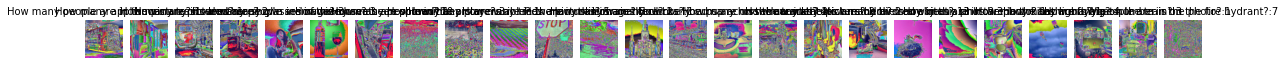

Batch 1


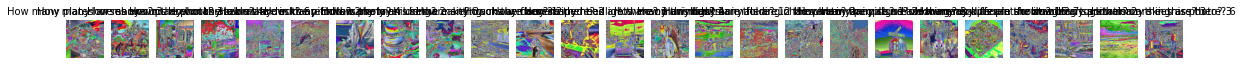

Batch 2


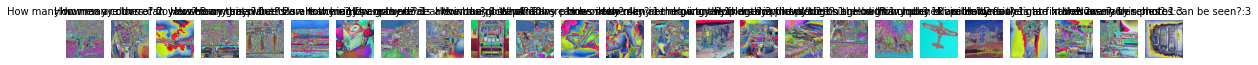

Batch 3


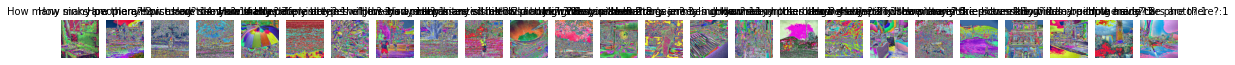

Batch 4


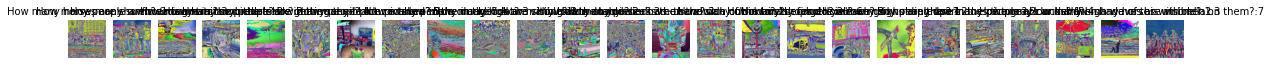

Batch 5


KeyboardInterrupt: ignored

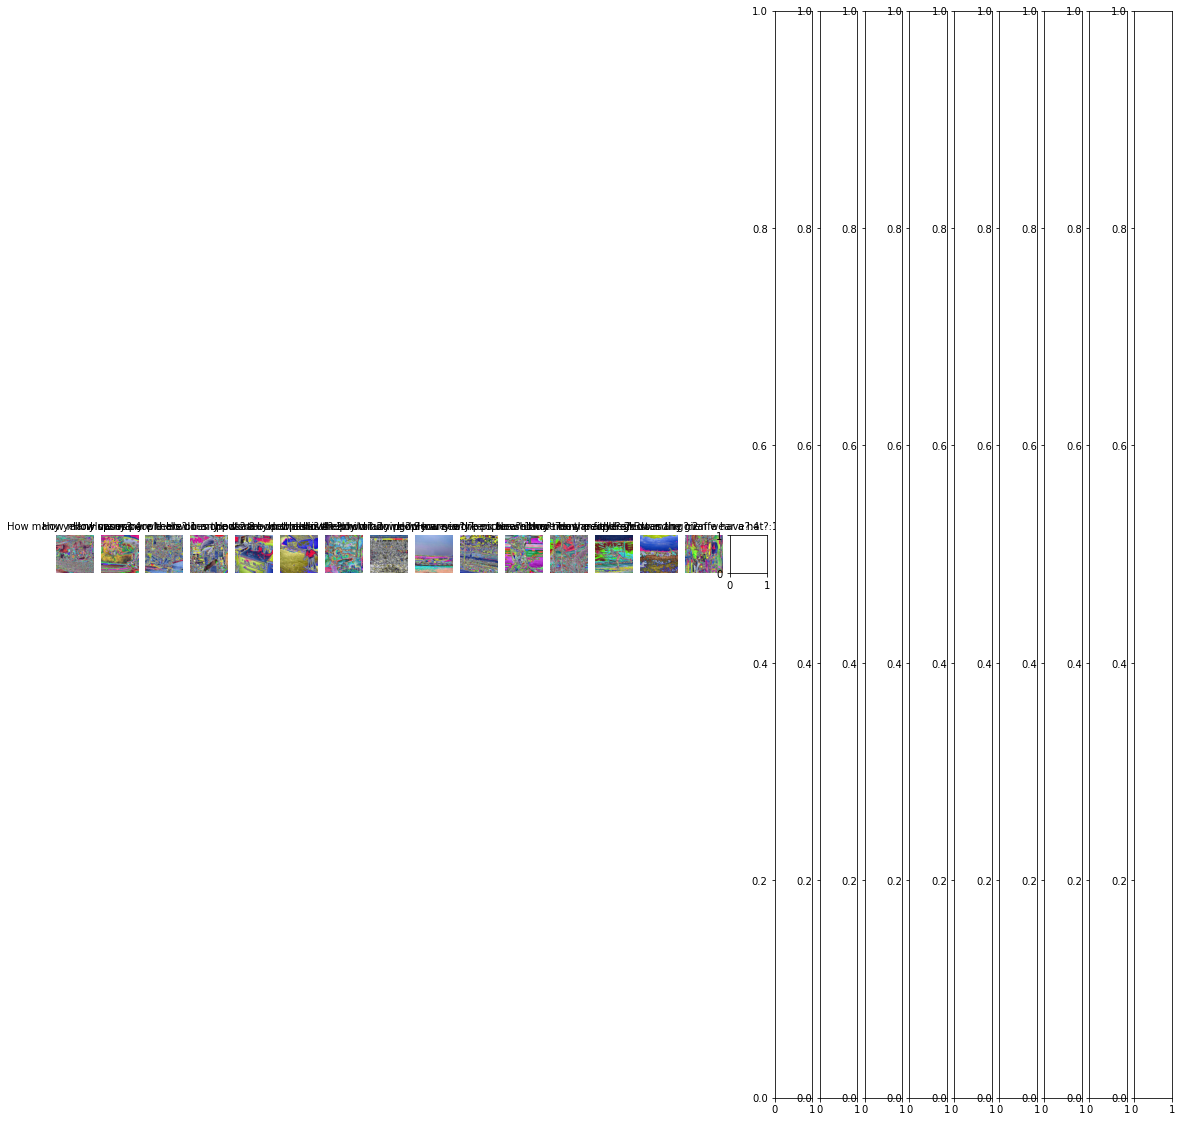

In [ ]:
for i, (image, question, annotation) in enumerate(dl):
    print ("Batch %d" % i)

    f, axarr = plt.subplots( 1,batch_size,figsize=(20,20))
    for j in range(batch_size):
        img = transforms.functional.to_pil_image(image[j])
        axarr[j].imshow(img)
        #axarr[j].set_title(question[j]+":"+annotation[j],fontsize=9,color='white')
        axarr[j].set_title(question[j]+":"+annotation[j],fontsize=10)
        axarr[j].axis('off')
    plt.show()



##(Optional) VISION Custom Model Verification

#Model VQA1

## VISION INITIALIZATION: Custom RESNET model based on [RESNET](https://pytorch.org/hub/pytorch_vision_resnet/ )


In [ ]:
stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
customresnet18model = nn.Sequential(*(list(stdresnet18model.children())[:-1]))


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
customresnet18model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

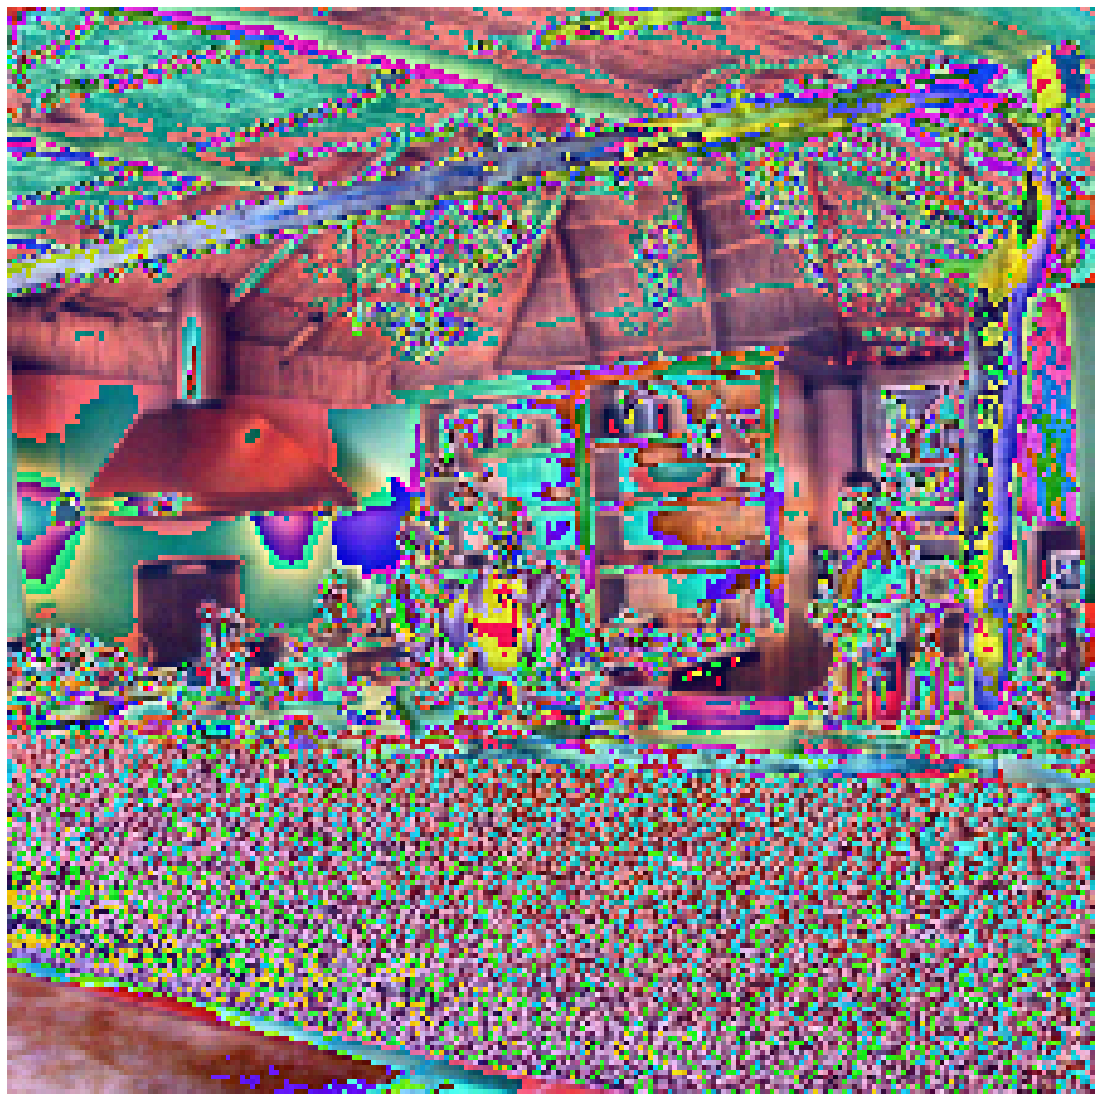

In [ ]:
f, axarr = plt.subplots(1,figsize=(20,20))
imgtestmodel = transforms.functional.to_pil_image(image[0])
imgtestmodeltensor = image[0]
axarr.imshow(imgtestmodel)
axarr.axis('off')
plt.show()



In [ ]:
# Optional code to test custom model
#input_tensor = imgtestmodel
input_batch = image[0].unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    customresnet18model.to('cuda')

with torch.no_grad():
    output = customresnet18model(input_batch)

print(output.shape)
print(input_batch.shape)

torch.Size([1, 512, 1, 1])
torch.Size([1, 3, 224, 224])


In [ ]:
# Model 1.b ******** RETURN FC1 ********
# Model Parameters to be included
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    self.fc0 = nn.Linear(512, 4096)
    self.fc1 = nn.Linear(4096,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    #self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,512)) #Replaced batch_size by vqamodelimageinputbatch
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
    #x = self.fc0(point_wise_multiplication) #
    x = F.relu(self.fc0(point_wise_multiplication))
    # OLD only one FC x = F.relu(self.fc1(point_wise_multiplication))
    x = self.fc1(x)
    #x = F.relu(self.fc1(x))
    #x = F.softmax(x, dim=1)  # Replace dim=0 for dim = 1
    
    #x = self.last(x) 
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.c ******** RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ********
# Model Parameters to be included
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    self.fc0 = nn.Linear(512, 4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,512)) #Replaced batch_size by vqamodelimageinputbatch
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
    #x = self.fc0(point_wise_multiplication) #
    x = F.relu(self.fc0(point_wise_multiplication))
    # OLD only one FC x = F.relu(self.fc1(point_wise_multiplication))
    x = F.relu(self.fc01(x))
    x = self.fc1(x)
    #x = F.relu(self.fc1(x))
    #x = F.softmax(x, dim=1)  # Replace dim=0 for dim = 1
    
    #x = self.last(x) 
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.d ******** RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ******** Adding Drop Outs & Normalization
# https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd 
# Model Parameters to be included
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    self.fc0 = nn.Linear(512, 4096)
    self.BN4096 = nn.BatchNorm1d(4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.BN1024 = nn.BatchNorm1d(1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    self.do = nn.Dropout(0.5)
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,512)) #Replaced batch_size by vqamodelimageinputbatch
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
    
    #x = F.relu(self.fc0(point_wise_multiplication))
    x = self.fc0(point_wise_multiplication)
    x = self.BN4096(x)
    x = F.relu(x) 
    x = self.do(x)
    
    #x = F.relu(self.fc01(x))
    x = self.fc01(x)
    x = self.BN1024(x)
    x = F.relu(x)     
    x = self.do(x)
    x = self.fc1(x)
    
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.e ******** CONCAT RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ******** Adding Drop Outs & Normalization ************** CONCAT
# https://pytorch.org/docs/stable/generated/torch.cat.html
# https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd 
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    #self.fc0 = nn.Linear(512, 4096)
    self.fc0 = nn.Linear(1024, 4096)
    self.BN4096 = nn.BatchNorm1d(4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.BN1024 = nn.BatchNorm1d(1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    self.do = nn.Dropout(0.5)
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,512)) #Replaced batch_size by vqamodelimageinputbatch
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    #point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    #if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
    imagequestionconcat = torch.cat((vision, question), dim=1)
    if modeldebug: print("imagequestionconcat shape: " +str(imagequestionconcat.shape)) 

    #x = F.relu(self.fc0(point_wise_multiplication))
    #x = self.fc0(point_wise_multiplication)
    x = self.fc0(imagequestionconcat)
    x = self.BN4096(x)
    x = F.relu(x) 
    x = self.do(x)
    
    #x = F.relu(self.fc01(x))
    x = self.fc01(x)
    x = self.BN1024(x)
    x = F.relu(x)     
    x = self.do(x)
    x = self.fc1(x)
    
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.f ******** RESNET50 ***CONCAT RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ******** Adding Drop Outs & Normalization ************** CONCAT
# https://pytorch.org/docs/stable/generated/torch.cat.html
# https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd 
# https://pytorch.org/hub/pytorch_vision_resnet/
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    #self.fc0 = nn.Linear(2560, 4096)
    self.fc0 = nn.Linear(2560, 4096)
    self.BN4096 = nn.BatchNorm1d(4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.BN1024 = nn.BatchNorm1d(1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True) #-> 2048
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    self.do = nn.Dropout(0.5)
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    #if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    #if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,2048)) #Replaced batch_size by vqamodelimageinputbatch // 512->2048
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    #point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    #if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
        
    imagequestionconcat = torch.cat((vision, question), dim=1)
    if modeldebug: print("imagequestionconcat shape: " +str(imagequestionconcat.shape)) 

    #x = F.relu(self.fc0(point_wise_multiplication))
    #x = self.fc0(point_wise_multiplication)
    x = self.fc0(imagequestionconcat)
    x = self.BN4096(x)
    x = F.relu(x) 
    x = self.do(x)
    
    #x = F.relu(self.fc01(x))
    x = self.fc01(x)
    x = self.BN1024(x)
    x = F.relu(x)     
    x = self.do(x)
    x = self.fc1(x)
    
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.fB **** RESNET FROZEN - NO TRAINING ******** RESNET50 ***CONCAT RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ******** Adding Drop Outs & Normalization ************** CONCAT
# https://pytorch.org/docs/stable/generated/torch.cat.html
# https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd 
# https://pytorch.org/hub/pytorch_vision_resnet/
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    #self.fc0 = nn.Linear(2560, 4096)
    self.fc0 = nn.Linear(2560, 4096)
    self.BN4096 = nn.BatchNorm1d(4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.BN1024 = nn.BatchNorm1d(1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True) #-> 2048
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    for block in self.vqa1customresnet18model.children():
      for param in block.parameters():
        param.requires_grad = False
    
    self.do = nn.Dropout(0.5)
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    #if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    #if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,2048)) #Replaced batch_size by vqamodelimageinputbatch // 512->2048
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    #point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    #if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
        
    imagequestionconcat = torch.cat((vision, question), dim=1)
    if modeldebug: print("imagequestionconcat shape: " +str(imagequestionconcat.shape)) 

    #x = F.relu(self.fc0(point_wise_multiplication))
    #x = self.fc0(point_wise_multiplication)
    x = self.fc0(imagequestionconcat)
    x = self.BN4096(x)
    x = F.relu(x) 
    x = self.do(x)
    
    #x = F.relu(self.fc01(x))
    x = self.fc01(x)
    x = self.BN1024(x)
    x = F.relu(x)     
    x = self.do(x)
    x = self.fc1(x)
    
    #for block in self.vqa1customresnet18model.children():
    #  for param in block.parameters():
    #    print(param.requires_grad)

    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.fC **** RESNET FROZEN EXCEPT LAST CONVOLUTIONAL BLOCK ******** RESNET50 ***CONCAT RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ******** Adding Drop Outs & Normalization ************** CONCAT
# https://pytorch.org/docs/stable/generated/torch.cat.html
# https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd 
# https://pytorch.org/hub/pytorch_vision_resnet/
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    #self.fc0 = nn.Linear(2560, 4096)
    self.fc0 = nn.Linear(2560, 4096)
    self.BN4096 = nn.BatchNorm1d(4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.BN1024 = nn.BatchNorm1d(1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True) #-> 2048
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    for block in self.vqa1customresnet18model.children():
      for param in block.parameters():
        param.requires_grad = False
    
    botneck = self.vqa1customresnet18model[7]
    for layer in botneck.children():
      for param in layer.parameters():
        param.requires_grad = True

    for block in self.vqa1customresnet18model.children():
      for param in block.parameters():
        print(param.requires_grad)

    self.do = nn.Dropout(0.5)
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    #if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    #if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,2048)) #Replaced batch_size by vqamodelimageinputbatch // 512->2048
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    #point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    #if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
        
    imagequestionconcat = torch.cat((vision, question), dim=1)
    if modeldebug: print("imagequestionconcat shape: " +str(imagequestionconcat.shape)) 

    #x = F.relu(self.fc0(point_wise_multiplication))
    #x = self.fc0(point_wise_multiplication)
    x = self.fc0(imagequestionconcat)
    x = self.BN4096(x)
    x = F.relu(x) 
    x = self.do(x)
    
    #x = F.relu(self.fc01(x))
    x = self.fc01(x)
    x = self.BN1024(x)
    x = F.relu(x)     
    x = self.do(x)
    x = self.fc1(x)
    
    #for block in self.vqa1customresnet18model.children():
    #  for param in block.parameters():
    #    print(param.requires_grad)

    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.g ******** RESNET50 pointwise ***CONCAT RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ******** Adding Drop Outs & Normalization ************** CONCAT
# https://pytorch.org/docs/stable/generated/torch.cat.html
# https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd 
# https://pytorch.org/hub/pytorch_vision_resnet/
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    #self.fc0 = nn.Linear(2560, 4096)
    self.fc0 = nn.Linear(2048, 4096)
    self.BN4096 = nn.BatchNorm1d(4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.BN1024 = nn.BatchNorm1d(1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True) #-> 2048
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    self.do = nn.Dropout(0.5)
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    #if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    #if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,2048)) #Replaced batch_size by vqamodelimageinputbatch // 512->2048
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    #point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    #if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
        
    # Vision -> [vqamodelimageinputbatch,2048], question [[vqamodelimageinputbatch,512]] ->
    tensorones = torch.ones((vqamodelimageinputbatch, 1536))
    tensorones = tensorones.to(device)

    questionsones = torch.cat((question, tensorones), dim=1)
    questionsones = questionsones.to(device)
    if modeldebug: print("questionsones shape: " +str(questionsones.shape)) 

    point_wise_multiplication = vision * questionsones # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
    

    #x = F.relu(self.fc0(point_wise_multiplication))
    x = self.fc0(point_wise_multiplication)
    #x = self.fc0(imagequestionconcat)
    x = self.BN4096(x)
    x = F.relu(x) 
    x = self.do(x)
    
    #x = F.relu(self.fc01(x))
    x = self.fc01(x)
    x = self.BN1024(x)
    x = F.relu(x)     
    x = self.do(x)
    x = self.fc1(x)
    
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
# Model 1.gB *** NO ONES **** ******** RESNET50 pointwise ***CONCAT RETURN FC1 + LAYER (4096->1024 -> uniqueanswers) ******** Adding Drop Outs & Normalization ************** CONCAT
# https://pytorch.org/docs/stable/generated/torch.cat.html
# https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd 
# https://pytorch.org/hub/pytorch_vision_resnet/
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    #self.fc0 = nn.Linear(2560, 4096)
    self.fcquestionescale = nn.Linear(512, 2048)
    self.fc0 = nn.Linear(2048, 4096)
    self.BN4096 = nn.BatchNorm1d(4096)
    self.fc01 = nn.Linear (4096, 1024)
    self.BN1024 = nn.BatchNorm1d(1024)
    self.fc1 = nn.Linear(1024,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True) #-> 2048
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    self.do = nn.Dropout(0.5)
   # self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    #if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    #if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,2048)) #Replaced batch_size by vqamodelimageinputbatch // 512->2048
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    #point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    #if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
        
    # Vision -> [vqamodelimageinputbatch,2048], question [[vqamodelimageinputbatch,512]] ->
    #tensorones = torch.ones((vqamodelimageinputbatch, 1536))
    #tensorones = tensorones.to(device)

    #questionsones = torch.cat((question, tensorones), dim=1)
    #questionsones = questionsones.to(device)
    #if modeldebug: print("questionsones shape: " +str(questionsones.shape)) 

    # question -> [vqamodelinputbatch, 512] -> [vqamodelinputbatch, 2048]
    questions2048 = self.fcquestionescale(question)
    if modeldebug: print("questions2048 shape: " +str(questions2048.shape)) 

    #point_wise_multiplication = vision * questionsones # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    point_wise_multiplication = vision * questions2048 
    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
    

    #x = F.relu(self.fc0(point_wise_multiplication))
    x = self.fc0(point_wise_multiplication)
    #x = self.fc0(imagequestionconcat)
    x = self.BN4096(x)
    x = F.relu(x) 
    x = self.do(x)
    
    #x = F.relu(self.fc01(x))
    x = self.fc01(x)
    x = self.BN1024(x)
    x = F.relu(x)     
    x = self.do(x)
    x = self.fc1(x)
    
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
def annotation_hot_encoding (annot, annotdebug):
  # Based on sample in #https://discuss.pytorch.org/t/convert-int-into-one-hot-format/507/3  
  idxlist = []

  for i, answer in enumerate(annot):
    if annotdebug: 
       print("annotation", annot)
       print ("i", i)
       print( "answer", answer)
       print( "idxlist", idxlist)
    idx = uniqueanswers.index(answer) # uniqueanswers.index('12') # -> It returns the position for a given answer. e.g.: ['2', '12', '11', '7', '19', '3', '16', '5', '10', '14', '9', '15', '18', '17', '4', '6', '1', '20', '8', '13'] and value '12' answers is 1
    idxlist.append( idx)
  
  annotlist = torch.tensor(idxlist)
  tens = annotlist.reshape(len(annot),1) #batch->size replaced by len(annot)

  y_onehot = torch.FloatTensor(len(annot), uniqueanswerscount) #batch->size replaced by list(annot.size())[0]
  y_onehot.zero_()
  y_onehot.scatter_(1, tens, 1)

  if annotdebug:
    print(uniqueanswers)
    print(answer)
    print(annotlist)
    print(tens)
    print(y_onehot)
    
  return annotlist, y_onehot


In [ ]:
# ********************* MODEL TEST - MODEL EVALUATION *******************************************
#For each batch execute model and measure accuracy without changing gradients

def ModelTest (model, modeltestdebug):
  #root_dir = "drive/My Drive/aidl" # 750 initial images
  #root_dir = "drive/My Drive/aidl/model5000_1_20" # 5000  images Sept-2nd

  
  
  test_trightanswers = 0
  test_timages = 0
  test_baccuracy = 0
  test_aaccuracy = 0

  test_numberimages = 0

  test_transquestions = transforms.ToTensor()

  test_batch_size = 10

  # Load test Dataset
  #test_ds = TestDataset("drive/My Drive/aidl",train=False,transform=t)
  test_ds = TestDataset(root_dir,train=False,transform=t)
  test_dl = DataLoader(test_ds,batch_size=test_batch_size,shuffle=True,num_workers=4)

  test_uniqueanswersset= set()
  for i in test_dl.dataset.annotations:
    test_uniqueanswersset.add(i['multiple_choice_answer'])
    test_uniqueanswerscount = len(test_uniqueanswersset)
    test_uniqueanswers = list(test_uniqueanswersset)

  with torch.no_grad():
    for i, (test_imagesinput, test_question, test_annotation) in enumerate(test_dl):
      
      test_numberimages += test_batch_size
      if modeltestdebug: print ("Model Test Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy", i, test_numberimages, test_timages, test_trightanswers, test_baccuracy, test_aaccuracy)
        
      #test_questions = sentence_embedding_generator(question)
      test_questions = sentence_embedding_generator(test_question)
      #test_qtrans= test_transquestions(questions.numpy())
      test_qtrans= test_transquestions(test_questions.numpy())
      
      test_imagesinput = test_imagesinput.to(device)
      test_qtrans = test_qtrans.squeeze_(0).to(device)
      
      model = model.eval()
      test_vqa1answers = model(test_imagesinput, test_qtrans, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
      test_targettensor, test_encoded_annotations = annotation_hot_encoding(test_annotation, annotdebug = False) #targettenso it's 1D vector where each value it's indicating the expected class index

      test_targettensor = test_targettensor.to(device)
      
      # ACCURACY 
      test_bcomparison = (test_vqa1answers.argmax(dim=1) == test_targettensor).float()
      test_timages += test_bcomparison.size()[0]
      test_trightanswers += test_bcomparison.sum().item()
      test_baccuracy = test_bcomparison.mean().item() # % 1-> 100%
      test_aaccuracy = test_trightanswers/test_timages
 
    if modeltestdebug: print (" Model Test Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy", i, test_numberimages, test_timages, test_trightanswers, test_baccuracy, test_aaccuracy)
    
    model=model.train()

  return test_aaccuracy

#acc = ModelTest(vqa1, modeltestdebug=True)
#print(acc)

In [ ]:
acc = ModelTest(vqa1, modeltestdebug=False)
print(acc)

NameError: ignored

In [ ]:
#VQA1 Training

vqa1 = VQA1()
vqa1 = vqa1.to(device)

print(vqa1)

#root_dir = "drive/My Drive/aidl" # 750 initial images
#root_dir = "drive/My Drive/aidl/model5000_1_20" # 5000  images Sept-2nd
#root_dir = "drive/My Drive/aidl/model10000_1_20" # 10000  images Oct-9th
root_dir = "drive/My Drive/aidl/model10000_yes_no" # 10000  images Oct-9th

epochs = 60 #120 #30 #30
batch_size = 25 #10 
lastloss=0
#vqa1 = vqa1.to(device)
j=0


criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(vqa1.parameters(), lr=0.001) #initial lr=0.001 - Prova 0.0001
optimizer = optim.Adam(vqa1.parameters(), lr=0.0005) # 0.0005 Oct-10th 16:33 per test 1.f initial lr=0.001 - Prova 0.0001

fixquestion = torch.tensor((), dtype=torch.float32) # Float 32 it's the output of the resnet model
fixquestion = fixquestion.new_ones((batch_size, 512)) ## torch.Size([5, 512]) // torch.float32 //  tensor([[1., 1., 1.,  ..., 1., 1., 1.], ****  [1., 1., 1.,  ..., 1., 1., 1.]])

numberimages = 0
trightanswers = 0
timages = 0
baccuracy = 0
aaccuracy = 0

batch_update = False

transquestions = transforms.ToTensor()

for epoch in range(epochs):
  # Load images
  #ds = TestDataset("drive/My Drive/aidl",train=True,transform=t)
  ds = TestDataset(root_dir,train=True,transform=t)
  dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=4)

  uniqueanswersset= set()
  for i in dl.dataset.annotations:
    #print(i['multiple_choice_answer'])
    uniqueanswersset.add(i['multiple_choice_answer'])

  uniqueanswerscount = len(uniqueanswersset)
  uniqueanswers = list(uniqueanswersset)
  #print(uniqueanswers)
  #print(uniqueanswerscount)



  for i, (imagesinput, question, annotation) in enumerate(dl):
    #for j in range(1,1000):
      numberimages = numberimages + batch_size
      if batch_update: print ("Training Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy", epoch, i, j, numberimages, lastloss, timages, trightanswers, baccuracy, aaccuracy)
      
      questions = sentence_embedding_generator(question)
      qtrans= transquestions(questions.numpy())
            
      optimizer.zero_grad()
      
      imagesinput = imagesinput.to(device)
      #fixquestion = fixquestion.to(device)
      qtrans = qtrans.squeeze_(0).to(device)
      

      #vqa1answers = vqa1(imagesinput, fixquestion, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
      vqa1answers = vqa1(imagesinput, qtrans, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
      targettensor, encoded_annotations = annotation_hot_encoding(annotation, annotdebug = False) #targettenso it's 1D vector where each value it's indicating the expected class index

      targettensor = targettensor.to(device)

      loss = criterion(vqa1answers, targettensor)
      lastloss = loss.item()
      
      # ACCURACY
      #bcomparison = (testvqa1answers.argmax(dim=1) == targettensor).float()
      bcomparison = (vqa1answers.argmax(dim=1) == targettensor).float()
      timages += bcomparison.size()[0]
      trightanswers += bcomparison.sum().item()
      baccuracy = bcomparison.mean().item() # % 1-> 100%
      aaccuracy = trightanswers/timages

      #Measure accuracy: vqa1answers through argmax we'll get the class and this is to be compared with targettensor and calculate how many are equal or not
      # Sample from Dani MNIST MLP
      #def accuracy(probabilities, labels):
      # probabilities = [64, 10]
      # pred = probabilities.argmax(dim=1)
      #return (pred == labels).float().mean().item()


      loss.backward()
      optimizer.step()

  print ("Training Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy", epoch, i, j, numberimages, lastloss, timages, trightanswers, baccuracy, aaccuracy)
  modeltestaccuracy = ModelTest(vqa1, modeltestdebug = False ) 
  print("*** Model Test Accuracy:", modeltestaccuracy)
    
  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


VQA1(
  (fc0): Linear(in_features=2048, out_features=4096, bias=True)
  (BN4096): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc01): Linear(in_features=4096, out_features=1024, bias=True)
  (BN1024): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (vqa1customresnet18model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

KeyboardInterrupt: ignored

In [ ]:
print(vqa1)
del vqa1
print(vqa1)

# ADAPTIVE LEARNING RATE FOR MODEL 1.F

In [ ]:
# Adaptive https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/62840b1eece760d5e42593187847261f/transfer_learning_tutorial.ipynb#scrollTo=oVy8JnxUa2Cl
from torch.optim import lr_scheduler
import time

In [ ]:
#VQA1 ADAPTATIVE Training
from torch.optim import lr_scheduler

del vqa1
vqa1 = VQA1()
vqa1 = vqa1.to(device)

print(vqa1)

#root_dir = "drive/My Drive/aidl" # 750 initial images
#root_dir = "drive/My Drive/aidl/model5000_1_20" # 5000  images Sept-2nd
root_dir = "drive/My Drive/aidl/model10000_1_20" # 10000  images Oct-9th
#root_dir = "drive/My Drive/aidl/model10000_yes_no" # 10000  images Oct-23rd

epochs = 50 #120 #30 #30
batch_size = 25 #10 
lastloss=0
j=0


criterion = nn.CrossEntropyLoss()
# Clàssic optimizer = optim.Adam(vqa1.parameters(), lr=0.001) #initial lr=0.001 - Prova 0.0001
#optimizer = optim.Adam(vqa1.parameters(), lr=0.0005) # 0.0005 Oct-10th 16:33 per test 1.f initial lr=0.001 - Prova 0.0001
#optimizer = optim.Adam(vqa1.parameters(), lr=0.01) #initial lr=0.001 - Prova 0.0001
optimizer = optim.Adam(vqa1.parameters(), lr=0.0030) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

# Oct-23 19h ->  optimizer = optim.Adam(vqa1.parameters(), lr=0.1) 

#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Oct-23 19h -> scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.95)

fixquestion = torch.tensor((), dtype=torch.float32) # Float 32 it's the output of the resnet model
fixquestion = fixquestion.new_ones((batch_size, 512)) ## torch.Size([5, 512]) // torch.float32 //  tensor([[1., 1., 1.,  ..., 1., 1., 1.], ****  [1., 1., 1.,  ..., 1., 1., 1.]])

numberimages = 0
trightanswers = 0
timages = 0
baccuracy = 0
aaccuracy = 0

batch_update = False

transquestions = transforms.ToTensor()

for epoch in range(epochs):
  # Load images
  #ds = TestDataset("drive/My Drive/aidl",train=True,transform=t)
  ds = TestDataset(root_dir,train=True,transform=t)
  dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=4)

  uniqueanswersset= set()
  for i in dl.dataset.annotations:
    #print(i['multiple_choice_answer'])
    uniqueanswersset.add(i['multiple_choice_answer'])

  uniqueanswerscount = len(uniqueanswersset)
  uniqueanswers = list(uniqueanswersset)
  #print(uniqueanswers)
  #print(uniqueanswerscount)



  for i, (imagesinput, question, annotation) in enumerate(dl):
    #for j in range(1,1000):
      numberimages = numberimages + batch_size
      if batch_update: print ("Training Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy", epoch, i, j, numberimages, lastloss, timages, trightanswers, baccuracy, aaccuracy)
      
      questions = sentence_embedding_generator(question)
      qtrans= transquestions(questions.numpy())
            
      optimizer.zero_grad()
      
      imagesinput = imagesinput.to(device)
      #fixquestion = fixquestion.to(device)
      qtrans = qtrans.squeeze_(0).to(device)
      

      #vqa1answers = vqa1(imagesinput, fixquestion, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
      vqa1answers = vqa1(imagesinput, qtrans, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
      targettensor, encoded_annotations = annotation_hot_encoding(annotation, annotdebug = False) #targettenso it's 1D vector where each value it's indicating the expected class index

      targettensor = targettensor.to(device)

      loss = criterion(vqa1answers, targettensor)
      lastloss = loss.item()
      
      # ACCURACY
      #bcomparison = (testvqa1answers.argmax(dim=1) == targettensor).float()
      bcomparison = (vqa1answers.argmax(dim=1) == targettensor).float()
      timages += bcomparison.size()[0]
      trightanswers += bcomparison.sum().item()
      baccuracy = bcomparison.mean().item() # % 1-> 100%
      aaccuracy = trightanswers/timages

      #Measure accuracy: vqa1answers through argmax we'll get the class and this is to be compared with targettensor and calculate how many are equal or not
      # Sample from Dani MNIST MLP
      #def accuracy(probabilities, labels):
      # probabilities = [64, 10]
      # pred = probabilities.argmax(dim=1)
      #return (pred == labels).float().mean().item()


      loss.backward()
      optimizer.step()
      

  print ("Training Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy-lr", epoch, i, j, numberimages, lastloss, timages, trightanswers, baccuracy, aaccuracy, scheduler.get_last_lr() )
  modeltestaccuracy = ModelTest(vqa1, modeltestdebug = False ) 
  print("*** Model Test Accuracy:", modeltestaccuracy)
  scheduler.step()  
  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


VQA1(
  (fc0): Linear(in_features=2560, out_features=4096, bias=True)
  (BN4096): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc01): Linear(in_features=4096, out_features=1024, bias=True)
  (BN1024): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (vqa1customresnet18model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:
print(scheduler.get_last_lr())

[0.001]


# HISTORICAL RESULTS
* Aug-26th:
  *   VQA1, 16:25-> epochs=30, batch_size=10, optim.SGD(vqa1.parameters(), lr=0001, momentum=0.9)-> Epoch-Batch-Image-Loss 29 74 22500 2.5493381023406982
  *   VQA1, 16:34-> epochs=30, batch_size=10, optim.SGD(vqa1.parameters(), lr=0.01, momentum=0.9) -> Epoch-Batch-Image-Loss 29 74 22500 2.583622455596924
* Aug-27th:
  *    VQA1, 17:49-> Same batch_size=10 used 10 times with optimizer = optim.Adam(vqa1.parameters(), lr=0.001) -> Epoch-Batch-J-Image-Loss 0 0 1 10 0, Epoch-Batch-J-Image-Loss 0 0 2 20 3.102071762084961, Epoch-Batch-J-Image-Loss 0 0 3 30 0.917910099029541, Epoch-Batch-J-Image-Loss 0 0 4 40 0.14280571043491364
Epoch-Batch-J-Image-Loss 0 0 5 50 0.030064750462770462, Epoch-Batch-J-Image-Loss 0 0 6 60 0.009714377112686634
Epoch-Batch-J-Image-Loss 0 0 7 70 0.004063896834850311, Epoch-Batch-J-Image-Loss 0 0 8 80 0.002091873437166214
Epoch-Batch-J-Image-Loss 0 0 9 90 0.0012533303815871477
* Aug-28th:
  *    VQA1 (512 pointwise->4096->20), 16:23 -> batch_size=10 & optimizer = optim.Adam(vqa1.parameters(), lr=0.000005)       -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 29 74 0 22500 0.31454962491989136 22490 3209.0 0.10000000149011612 **Accuracy = (3209/22490) = 14.2%**
  *    VQA1BIG (512->1024->pointwise->4096->20), 17:08 ->batch_size=10 & optimizer = optim.Adam(vqa1.parameters(), lr=0.000005)     -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 29 74 0 22500 0.1657908409833908 22490 2579.0 0.30000001192092896 **Accuracy = (2579/22490) = 11.4% **
  * VQA1BIG (512->512->pointwise->4096->20) 17:25 -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 29 74 0 22500 0.0900210440158844 22490 60.0 0.0 Accuracy (60/22490) = 0.2%
  * VQA1BIG (512->1024->pointwise->8192->20)Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 29 74 0 22500 0.06717438995838165 22490 1170.0 0.0 Accuracy(1170/22490) = 5.2%. Note: Adding Rely on 512 -> 1024 Accuracy = 2.6%
  * VQA1BIG (512->pointwise->4096->2048->20) -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 29 74 0 22500 0.508860170841217 22490 90.0 0.0 Accuracy (90/22490)=0.4%
  * VQA1BIG 18:23 ->Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 29 74 0 22500 0.6910462379455566 22490 330.0 0.0 ???
*Aug-31st:
  * VQA1(512->4096->20) -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 29 74 0 22500 0.5113711953163147 22490 1320.0 0.20000000298023224 Accuracy (1320/22490) = 5.8%
  * VQA1 (Model below) -Notebook just restarted / edited the call to annotations as it was using 'testvqa...' instead of 'test'-> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 29 74 0 22500 1.692568063735962 22490 6511.0 0.30000001192092896 0.28950644730991554 -> Accuracy (6511 / 22490) = 28.9%
 
      class VQA1(nn.Module):
          def __init__(self):
            super(VQA1, self).__init__()
            # 512 -> 1000 Fully connected
            self.fc0 = nn.Linear(512, 4096)
            self.fc1 = nn.Linear(4096,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
            vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
            self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
            self.last = torch.nn.LogSoftmax(dim=1)
        

                  def forward(self, image, question, modeldebug):
                    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
                    vqamodelimageinputbatch = list(image.size())[0]
                    if modeldebug: print(vqamodelimageinputbatch)
                    resnetinputimage = image
                    if modeldebug: print(resnetinputimage)
                    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
                    vision = self.vqa1customresnet18model(resnetinputimage)
                    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
                    vision = torch.reshape(vision, (vqamodelimageinputbatch,512)) #Replaced batch_size by vqamodelimageinputbatch
                    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
                    if modeldebug: print("question shape:" + str(question.shape)) #?
                    point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
                    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
                    #x = self.fc0(point_wise_multiplication) #
                    x = F.relu(self.fc0(point_wise_multiplication))
                    # OLD only one FC x = F.relu(self.fc1(point_wise_multiplication))
                    x = self.fc1(x)
                    #x = F.relu(self.fc1(x))
                    #x = F.softmax(x, dim=1)  # Replace dim=0 for dim = 1
                    
                    x = self.last(x) 
                    if modeldebug: print("x->", x.shape, x)
                    return x 


  *   VQA1 - Same model than before - 23:08 ->Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 29 74 0 22500 1.5322349071502686 22490 6602.0 0.30000001192092896 ** 0.293552690084482**
  *   VQA1 - Same model than before - 60 epochs - Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 59 74 0 45000 0.9366569519042969 44990 15196.0 0.800000011920929 ** 0.33776394754389866 **
  *    VQA1 - Changed 4096 to 8192 . 23:42 -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 29 74 0 22500 1.5494552850723267 22490 6617.0 0.30000001192092896 0.29421965317919074
  *   VQA1 - Changed 4096 to 1024 - 23:48 -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 29 74 0 22500 2.148186206817627 22490 6439.0 0.20000000298023224 0.2863050244553135
  *   VQA1 - Model 4096 90! epochs - 23:50 -> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 89 74 0 67500 1.2674119472503662 67490 29898.0 0.5 0.44299896280930506

* Sept-2nd, 2020 (with optimizer = optim.Adam(vqa1.parameters(), lr=0.000005))
  * VQA1 -Model 4096 30 epochs (using previous model) ->Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 29 74 0 22500 1.7400506734848022 22490 6582.0 0.20000000298023224 0.29266340595820367
  *    VQA1 - odel 4096 WITHOUT LOGSOFTMAX - returning output of fc1 - Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 29 74 0 22500 1.5630381107330322 22490 6520.0 0.4000000059604645 0.28990662516674076
  *    VQA1 - Model 4096 90 epochs WITHOUT LOGSOFTMAX  - Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 89 74 0 67500 1.2384707927703857 67490 30428.0 0.6000000238418579 0.45085197807082533
  *    VQA1 - Model 4096 90 epochs WITHOUT LOGSOFTMAX   & Relu(4096)->Relu(1024)->20 --> Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 29 74 0 22500 1.4943759441375732 22490 7438.0 0.30000001192092896 0.3307247665629168
  * VQA 1 90 epochs- Model 4096 90 epochs WITHOUT LOGSOFTMAX   & Relu(4096)->Relu(1024)->20 ->Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy-AcumAccuracy 89 74 0 67500 0.5077808499336243 67490 36206.0 0.9000000357627869 0.5364646614313232
  ** TEST RESULTS -> Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 24 250 240 48.0 0.30000001192092896 0.2

In [ ]:
# Test vqa1
batch_size = 1
testvqa1 = VQA1()




input_batch = image[0].unsqueeze(0) # create a mini-batch as expected by the model
fixquestion = torch.tensor((), dtype=torch.float32) # Float 32 it's the output of the resnet model
fixquestion = fixquestion.new_ones((list(input_batch.size())[0], 512)) #replaced batch_size by list(image.size())[0]

# move the input and model to GPU for speed if available

testvqa1 = testvqa1.to(device)
input_batch = input_batch.to(device)
fixquestion = fixquestion.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testvqa1.parameters(), lr=0.000005) #initial lr=0.001

testvqa1answers = testvqa1(input_batch, fixquestion, modeldebug=True)

print("annotation type", type(annotation))
print("annotation[0] type", type(annotation[0]))

targettensor, encoded_annotations = annotation_hot_encoding(annotation[0], annotdebug = True)

print(testvqa1answers)
print(uniqueanswers)
print(annotation[0])
print(targettensor)

targettensor = targettensor.to(device)
print(targettensor.device)
#testvqa1answers.to(device)


loss = criterion(testvqa1answers, targettensor)
print(loss)

trightanswers = 0
timages = 0

bcomparison = (testvqa1answers.argmax(dim=1) == targettensor).float()
#bcomparison = (mdans == mdtarget).float()
timages += bcomparison.size()[0]
trightanswers += bcomparison.sum().item()
baccuracy = bcomparison.mean().item() # % 1-> 100%


print(bcomparison)
print(timages)
print(trightanswers)
print(baccuracy)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


1
tensor([[[[ 0.4508,  0.4337,  0.4508,  ..., -0.3369, -0.3027, -0.3198],
          [ 0.3823,  0.3309,  0.2967,  ..., -0.2684, -0.2513, -0.2513],
          [ 0.2624,  0.1939,  0.1426,  ..., -0.2171, -0.1657, -0.1828],
          ...,
          [ 1.0502,  0.9988,  1.0159,  ...,  0.9646,  0.9303,  0.8789],
          [ 1.0502,  0.9817,  0.9817,  ...,  0.9988,  0.9474,  0.9303],
          [ 0.8961,  0.8618,  0.8276,  ...,  0.9474,  0.9474,  0.9817]],

         [[ 0.6429,  0.6254,  0.6429,  ...,  0.0126,  0.0126,  0.0301],
          [ 0.5728,  0.5378,  0.5203,  ...,  0.0651,  0.0826,  0.1001],
          [ 0.4678,  0.4153,  0.3803,  ...,  0.1176,  0.1877,  0.1702],
          ...,
          [ 1.0630,  1.0105,  1.0280,  ...,  0.9580,  0.9230,  0.8529],
          [ 1.0455,  1.0105,  0.9930,  ...,  0.9930,  0.9580,  0.9055],
          [ 0.9230,  0.8880,  0.8179,  ...,  0.9405,  0.9405,  0.9755]],

         [[ 0.5311,  0.5311,  0.5485,  ..., -0.0615, -0.0441, -0.0441],
          [ 0.4265,  0.3742,

ValueError: ignored

In [ ]:
class VQA1Big(nn.Module):
   def __init__(self):
    super(VQA1Big, self).__init__()
    self.fc0 = nn.Linear(512, 4096)
    self.fc1 = nn.Linear(4096,uniqueanswerscount) 

    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    self.last = torch.nn.LogSoftmax(dim=1)
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,512)) #Replaced batch_size by vqamodelimageinputbatch
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    point_wise_multiplication = vision * question
    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) 
    x = F.relu(self.fc0(point_wise_multiplication))
    #x = self.fc1(x)
    x = F.relu(self.fc1(x))
    #x = F.softmax(x, dim=1)  # Replace dim=0 for dim = 1
    x = self.last(x) 
    if modeldebug: print("x->", x.shape, x)
    return x 
   

In [ ]:
# Test vqa1Big()
batch_size = 1
testvqa1big = VQA1Big()




input_batch = image[0].unsqueeze(0) # create a mini-batch as expected by the model
fixquestion = torch.tensor((), dtype=torch.float32) # Float 32 it's the output of the resnet model
fixquestion = fixquestion.new_ones((list(input_batch.size())[0], 512)) #replaced batch_size by list(image.size())[0]

# move the input and model to GPU for speed if available

testvqa1big = testvqa1big.to(device)
input_batch = input_batch.to(device)
fixquestion = fixquestion.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(testvqa1.parameters(), lr=0.000005) #initial lr=0.001

testvqa1answers = testvqa1big(input_batch, fixquestion, modeldebug=True)

print("annotation type", type(annotation))
print("annotation[0] type", type(annotation[0]))

targettensor, encoded_annotations = annotation_hot_encoding(annotation[0], annotdebug = False)

print(testvqa1answers)
print(uniqueanswers)
print(annotation[0])
print(targettensor)

targettensor = targettensor.to(device)
print(targettensor.device)
#testvqa1answers.to(device)


loss = criterion(testvqa1answers, targettensor)
print(loss)

trightanswers = 0
timages = 0

bcomparison = (testvqa1answers.argmax(dim=1) == targettensor).float()
#bcomparison = (mdans == mdtarget).float()
timages += bcomparison.size()[0]
trightanswers += bcomparison.sum().item()
baccuracy = bcomparison.mean().item() # % 1-> 100%


print(bcomparison)
print(timages)
print(trightanswers)
print(baccuracy)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


1
tensor([[[[ 0.4508,  0.4337,  0.4508,  ..., -0.3369, -0.3027, -0.3198],
          [ 0.3823,  0.3309,  0.2967,  ..., -0.2684, -0.2513, -0.2513],
          [ 0.2624,  0.1939,  0.1426,  ..., -0.2171, -0.1657, -0.1828],
          ...,
          [ 1.0502,  0.9988,  1.0159,  ...,  0.9646,  0.9303,  0.8789],
          [ 1.0502,  0.9817,  0.9817,  ...,  0.9988,  0.9474,  0.9303],
          [ 0.8961,  0.8618,  0.8276,  ...,  0.9474,  0.9474,  0.9817]],

         [[ 0.6429,  0.6254,  0.6429,  ...,  0.0126,  0.0126,  0.0301],
          [ 0.5728,  0.5378,  0.5203,  ...,  0.0651,  0.0826,  0.1001],
          [ 0.4678,  0.4153,  0.3803,  ...,  0.1176,  0.1877,  0.1702],
          ...,
          [ 1.0630,  1.0105,  1.0280,  ...,  0.9580,  0.9230,  0.8529],
          [ 1.0455,  1.0105,  0.9930,  ...,  0.9930,  0.9580,  0.9055],
          [ 0.9230,  0.8880,  0.8179,  ...,  0.9405,  0.9405,  0.9755]],

         [[ 0.5311,  0.5311,  0.5485,  ..., -0.0615, -0.0441, -0.0441],
          [ 0.4265,  0.3742,

#Training
High Level Structure from [Cifar10_tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
import torch.optim as optim


vqa1 = VQA1()
vqa1 = vqa1.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(vqa1.parameters(), lr=0.01, momentum=0.9) #Initial values

#optimizer = optim.SGD(vqa1.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(vqa1.parameters(), lr=0.000005) #initial lr=0.001

# Other Options:
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.BCELoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
#VQABIG Test
vqa1 = VQA1Big()
vqa1 = vqa1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vqa1.parameters(), lr=0.000005) #initial lr=0.001

fixquestion = torch.tensor((), dtype=torch.float32) # Float 32 it's the output of the resnet model
fixquestion = fixquestion.new_ones((batch_size, 512)) ## torch.Size([5, 512]) // torch.float32 //  tensor([[1., 1., 1.,  ..., 1., 1., 1.], ****  [1., 1., 1.,  ..., 1., 1., 1.]])

numberimages = 0
epochs = 30
batch_size = 10 
lastloss=0
#vqa1 = vqa1.to(device)
j=0

trightanswers = 0
timages = 0
baccuracy = 0

for epoch in range(epochs):
  # Load images
  ds = TestDataset("drive/My Drive/aidl",train=True,transform=t)
  dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=4)

  uniqueanswersset= set()
  for i in dl.dataset.annotations:
    #print(i['multiple_choice_answer'])
    uniqueanswersset.add(i['multiple_choice_answer'])

  uniqueanswerscount = len(uniqueanswersset)
  uniqueanswers = list(uniqueanswersset)
  #print(uniqueanswers)
  #print(uniqueanswerscount)



  for i, (imagesinput, question, annotation) in enumerate(dl):
    #for j in range(1,10):
      numberimages = numberimages + batch_size
      print ("Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy", epoch, i, j, numberimages, lastloss, timages, trightanswers, baccuracy)
      #print(imagesinput.shape) # torch.Size([5, 3, 224, 224])

      #rndquest5=torch.randn(5,512) #torch.Size([5, 512])
      optimizer.zero_grad()
      
      imagesinput = imagesinput.to(device)
      fixquestion = fixquestion.to(device)
      #annotation = annotation.to(device)

      vqa1answers = vqa1(imagesinput, fixquestion, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
      targettensor, encoded_annotations = annotation_hot_encoding(annotation, annotdebug = False) #targettenso it's 1D vector where each value it's indicating the expected class index

      targettensor = targettensor.to(device)

      loss = criterion(vqa1answers, targettensor)
      lastloss = loss.item()
      
      # ACCURACY
      bcomparison = (testvqa1answers.argmax(dim=1) == targettensor).float()
      timages += bcomparison.size()[0]
      trightanswers += bcomparison.sum().item()
      baccuracy = bcomparison.mean().item() # % 1-> 100%

      #Measure accuracy: vqa1answers through argmax we'll get the class and this is to be compared with targettensor and calculate how many are equal or not
      # Sample from Dani MNIST MLP
      #def accuracy(probabilities, labels):
      # probabilities = [64, 10]
      # pred = probabilities.argmax(dim=1)
      #return (pred == labels).float().mean().item()


      loss.backward()
      optimizer.step() 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 0 0 10 0 0 0 0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 1 0 20 2.910290002822876 10 0.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 2 0 30 3.1154582500457764 20 0.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 3 0 40 2.9013140201568604 30 0.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 4 0 50 2.9678092002868652 40 0.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 5 0 60 3.014357328414917 50 0.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 6 0 70 3.0032451152801514 60 1.0 0.10000000149011612
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 7 0 80 2.982349157333374 70 1.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 8 0 90 2.8656413555145264 80 1.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 9 0 100 3.0178542137145996 90 1.0 0.0
Epoch-Batch-J-Image-Loss-timages-rightanswers-baccuracy 0 

## Model Result Verifications

# BACKUP

In [ ]:
"""
**Below initial code from Rafael
t = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((320,320)),
     transforms.ToTensor(),
    ])
** Below initial code from Pytorch RESNET documentation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
"""
t = transforms.Compose([
    transforms.ToPILImage(), # Required for Visualization based on code from Rafael. It wasn't on the standard documentation
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

ds = TestDataset("drive/My Drive/aidl",train=True,transform=t)
dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=4)

uniqueanswersset= set()
for i in dl.dataset.annotations:
  #print(i['multiple_choice_answer'])
  uniqueanswersset.add(i['multiple_choice_answer'])

uniqueanswerscount = len(uniqueanswersset)
uniqueanswers = list(uniqueanswersset)
print(uniqueanswers)
print(uniqueanswerscount)

['3', '18', '8', '7', '5', '17', '19', '10', '6', '11', '9', '16', '2', '15', '1', '4', '12', '20', '14', '13']
20


In [ ]:
# FROZEN - AQUEST FUNCIONA - Aug-25th 22:48
fixquestion = torch.tensor((), dtype=torch.float32) # Float 32 it's the output of the resnet model
fixquestion = fixquestion.new_ones((batch_size, 512)) ## torch.Size([5, 512]) // torch.float32 //  tensor([[1., 1., 1.,  ..., 1., 1., 1.], ****  [1., 1., 1.,  ..., 1., 1., 1.]])

numberimages = 0

for i, (imagesinput, question, annotation) in enumerate(dl):
    numberimages = numberimages + batch_size
    print ("Batch-Image", i, numberimages)
    #print(imagesinput.shape) # torch.Size([5, 3, 224, 224])

    #rndquest5=torch.randn(5,512) #torch.Size([5, 512])
    optimizer.zero_grad()
    
    imagesinput = imagesinput.to(device)
    fixquestion = fixquestion.to(device)
    #annotation = annotation.to(device)

    vqa1answers = vqa1(imagesinput, fixquestion, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
    targettensor, encoded_annotations = annotation_hot_encoding(annotation, annotdebug = False)

    targettensor = targettensor.to(device)

    loss = criterion(vqa1answers, targettensor)
    print(i, loss)

    loss.backward()
    optimizer.step()

Batch-Image 0 10
0 tensor(2.9900, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 1 20
1 tensor(2.9842, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 2 30
2 tensor(2.9952, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 3 40
3 tensor(3.0041, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 4 50
4 tensor(2.9995, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 5 60
5 tensor(2.9846, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 6 70
6 tensor(2.9786, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 7 80
7 tensor(3.0019, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 8 90
8 tensor(2.9904, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 9 100
9 tensor(3.0111, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 10 110
10 tensor(3.0003, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 11 120
11 tensor(2.9995, device='cuda:0', grad_fn=<NllLossBackward>)
Batch-Image 12 130
12 tensor(2.9994, device='cuda:0', gra

In [ ]:
fixquestion = torch.tensor((), dtype=torch.float32) # Float 32 it's the output of the resnet model
fixquestion = fixquestion.new_ones((5, 512)) ## torch.Size([5, 512]) // torch.float32 //  tensor([[1., 1., 1.,  ..., 1., 1., 1.], ****  [1., 1., 1.,  ..., 1., 1., 1.]])

for i, (imagesinput, question, annotation) in enumerate(dl):
    print ("Batch %d" % i)
    #print(imagesinput.shape) # torch.Size([5, 3, 224, 224])

    #rndquest5=torch.randn(5,512) #torch.Size([5, 512])
    optimizer.zero_grad()
    
    vqa1answers = vqa1(imagesinput, fixquestion, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
    
""" vqa1
Debug traces:
  Batch 0
  torch.Size([5, 3, 224, 224])
  resnetinputimage shape: torch.Size([5, 3, 224, 224])
  vision shape:torch.Size([5, 512, 1, 1])
  New vision shape:torch.Size([5, 512])
  question shape:torch.Size([5, 512])
  point_wise_multiplication shape: torch.Size([5, 512])
  torch.Size([5, 20])
  Batch 1
  ....
Results from vqa1 for a given batch of size 5
  tensor([[0.2092, 0.1888, 0.3992, 0.1351, 0.1927, 0.1720, 0.2277, 0.2179, 0.2247,
          0.1762, 0.2000, 0.1219, 0.2000, 0.1867, 0.1818, 0.2986, 0.1942, 0.1864,
          0.1555, 0.2000],
          [0.1835, 0.2153, 0.1804, 0.1986, 0.1927, 0.2600, 0.1383, 0.2406, 0.1539,
          0.2193, 0.2000, 0.1219, 0.2000, 0.1282, 0.1818, 0.1688, 0.1942, 0.2542,
          0.1490, 0.2000],
          [0.1835, 0.2132, 0.1696, 0.2080, 0.2293, 0.1983, 0.3391, 0.1750, 0.1468,
          0.1762, 0.2000, 0.1484, 0.2000, 0.2798, 0.1818, 0.2229, 0.1942, 0.1864,
          0.2675, 0.2000],
          [0.2404, 0.1940, 0.1201, 0.1857, 0.1927, 0.1063, 0.1450, 0.1193, 0.2243,
          0.2252, 0.2000, 0.1919, 0.2000, 0.1389, 0.2729, 0.1549, 0.1942, 0.1864,
          0.2682, 0.2000],
          [0.1835, 0.1888, 0.1307, 0.2727, 0.1927, 0.2635, 0.1499, 0.2472, 0.2503,
          0.2031, 0.2000, 0.4159, 0.2000, 0.2664, 0.1818, 0.1549, 0.2231, 0.1864,
          0.1598, 0.2000]], grad_fn=<SoftmaxBackward>)
**** THIS IS THE STARTING POINT FOR CALCULATING LOST *****
"""


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49


' vqa1\nDebug traces:\n  Batch 0\n  torch.Size([5, 3, 224, 224])\n  resnetinputimage shape: torch.Size([5, 3, 224, 224])\n  vision shape:torch.Size([5, 512, 1, 1])\n  New vision shape:torch.Size([5, 512])\n  question shape:torch.Size([5, 512])\n  point_wise_multiplication shape: torch.Size([5, 512])\n  torch.Size([5, 20])\n  Batch 1\n  ....\nResults from vqa1 for a given batch of size 5\n  tensor([[0.2092, 0.1888, 0.3992, 0.1351, 0.1927, 0.1720, 0.2277, 0.2179, 0.2247,\n          0.1762, 0.2000, 0.1219, 0.2000, 0.1867, 0.1818, 0.2986, 0.1942, 0.1864,\n          0.1555, 0.2000],\n          [0.1835, 0.2153, 0.1804, 0.1986, 0.1927, 0.2600, 0.1383, 0.2406, 0.1539,\n          0.2193, 0.2000, 0.1219, 0.2000, 0.1282, 0.1818, 0.1688, 0.1942, 0.2542,\n          0.1490, 0.2000],\n          [0.1835, 0.2132, 0.1696, 0.2080, 0.2293, 0.1983, 0.3391, 0.1750, 0.1468,\n          0.1762, 0.2000, 0.1484, 0.2000, 0.2798, 0.1818, 0.2229, 0.1942, 0.1864,\n          0.2675, 0.2000],\n          [0.2404, 0.194

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607502 ... -0.03242778 -0.04575741
   0.05370456]
 [ 0.05080861 -0.01652428  0.01573781 ...  0.00976659  0.03170123
   0.01788119]], shape=(2, 512), dtype=float32)


In [ ]:
# STOP USING IT!
# TBD with Python PROs if it could be optimized and / or included on the original class to avoid duplication of processing same data
# https://www.geeksforgeeks.org/python-get-unique-values-list/
# https://www.w3schools.com/python/python_sets.asp
# https://www.datacamp.com/community/tutorials/sets-in-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034343&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=20270&gclid=Cj0KCQjwhIP6BRCMARIsALu9LfkRv1PAKysC9UTAAFihRRqFofPPdyKUj1TF5Up_E8oMc5zqEIuN-msaAmfCEALw_wcB
uniqueanswersset= set()
for i in dl.dataset.annotations:
  #print(i['multiple_choice_answer'])
  uniqueanswersset.add(i['multiple_choice_answer'])

uniqueanswerscount = len(uniqueanswersset)
uniqueanswers = list(uniqueanswersset)
print(uniqueanswers)
print(uniqueanswerscount)



['17', '8', '2', '20', '3', '1', '9', '12', '13', '18', '16', '11', '10', '19', '14', '7', '6', '15', '5', '4']
20


In [ ]:
# ***************************** MODEL QUE ITERA I APREN FINS A 2.6/2.5 *************************************************
# Model Parameters to be included
# Input of Layer should be a parameters and it depends on Image and/or question -> RESNET18: 512, RESNET34:512, RESNET50: 2048, RESTNET152:2048
# Output of classificator depends on the total number of different possible answers -> uniqueanswerscount
# uniqueanswers és un array amb les respotes úniques a fer servir per donat el resultat del model buscar el text al que correspon la respota.
class VQA1(nn.Module):
   def __init__(self):
    super(VQA1, self).__init__()
    # 512 -> 1000 Fully connected
    self.fc1 = nn.Linear(512,uniqueanswerscount) # To Be Discussed if output should be 1000 or Unique values
    vqa1stdresnet18model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    self.vqa1customresnet18model = nn.Sequential(*(list(vqa1stdresnet18model.children())[:-1]))
    

   def forward(self, image, question, modeldebug):
    #resnetinputimage = image.unsqueeze(0) # torch.Size([1, 3, 224, 224])
    vqamodelimageinputbatch = list(image.size())[0]
    if modeldebug: print(vqamodelimageinputbatch)
    resnetinputimage = image
    if modeldebug: print(resnetinputimage)
    if modeldebug: print("resnetinputimage shape: " + str(resnetinputimage.shape)) #resnetinputimage shape: torch.Size([5, 3, 224, 224])
    vision = self.vqa1customresnet18model(resnetinputimage)
    if modeldebug: print("vision shape:" + str(vision.shape)) #vision shape:torch.Size([1, 512, 1, 1]) #vision shape:torch.Size([5, 512, 1, 1])
    vision = torch.reshape(vision, (vqamodelimageinputbatch,512)) #Replaced batch_size by vqamodelimageinputbatch
    if modeldebug: print("New vision shape:" + str(vision.shape)) #?
    if modeldebug: print("question shape:" + str(question.shape)) #?
    point_wise_multiplication = vision * question # image RESNET18: 512 -> Result 512 # ERROR -> point_wise_multiplication shape: torch.Size([1, 512, 1, 512])
    if modeldebug: print("point_wise_multiplication shape: " +str(point_wise_multiplication.shape)) #torch.Size([5, 512, 5, 512]) #point_wise_multiplication shape: torch.Size([5, 512, 5, 512])
    x = F.relu(self.fc1(point_wise_multiplication))
    x = F.softmax(x, dim=1) #torch.Size([1, 512, 1, 13]) # Replace dim=0 for dim = 1
    if modeldebug: print("x->", x.shape, x)
    return x 

In [ ]:
vqa1 = VQA1()
#question = torch.randn(512)
#print(torch.argmax(vqa1answer))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
#mdtarget = targettensor
#mdans = testvqa1answers.argmax(dim=1)

mdtarget = torch.tensor([12,10])
mdans = torch.tensor([12,5])

trightanswers = 0
timages = 0

bcomparison = (testvqa1answers.argmax(dim=1) == targettensor).float()
#bcomparison = (mdans == mdtarget).float()
timages += bcomparison.size()[0]
trightanswers += bcomparison.sum().item()
baccuracy = bcomparison.mean().item() # % 1-> 100%


print(bcomparison)
print(timages)
print(trightanswers)
print(baccuracy)

tensor([0.], device='cuda:0')
1
0.0
0.0


In [ ]:
# ********************* MODEL TEST - MODEL EVALUATION *******************************************
#For each batch execute model and measure accuracy without changing gradients

trightanswers = 0
timages = 0
baccuracy = 0
aaccuracy = 0

numberimages = 0

transquestions = transforms.ToTensor()

batch_size = 10

# Load test Dataset
ds = TestDataset("drive/My Drive/aidl",train=False,transform=t)
dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=4)

uniqueanswersset= set()
for i in dl.dataset.annotations:
  uniqueanswersset.add(i['multiple_choice_answer'])
  uniqueanswerscount = len(uniqueanswersset)
  uniqueanswers = list(uniqueanswersset)

with torch.no_grad():
  for i, (imagesinput, question, annotation) in enumerate(dl):
    numberimages += batch_size
    print ("Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy", i, numberimages, timages, trightanswers, baccuracy, aaccuracy)
      
    questions = sentence_embedding_generator(question)
    qtrans= transquestions(questions.numpy())
    
    imagesinput = imagesinput.to(device)
    qtrans = qtrans.squeeze_(0).to(device)
    
    vqa1answers = vqa1(imagesinput, qtrans, modeldebug=False) # vqa1answers is a torch.float32 tensor of [Batch, Classes] size. See comments below for a real example
    targettensor, encoded_annotations = annotation_hot_encoding(annotation, annotdebug = False) #targettenso it's 1D vector where each value it's indicating the expected class index

    targettensor = targettensor.to(device)
    
    # ACCURACY 
    bcomparison = (vqa1answers.argmax(dim=1) == targettensor).float()
    timages += bcomparison.size()[0]
    trightanswers += bcomparison.sum().item()
    baccuracy = bcomparison.mean().item() # % 1-> 100%
    aaccuracy = trightanswers/timages


Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 0 10 0 0 0 0
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 1 20 10 3.0 0.30000001192092896 0.3
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 2 30 20 5.0 0.20000000298023224 0.25
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 3 40 30 7.0 0.20000000298023224 0.23333333333333334
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 4 50 40 9.0 0.20000000298023224 0.225
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 5 60 50 14.0 0.5 0.28
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 6 70 60 16.0 0.20000000298023224 0.26666666666666666
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 7 80 70 18.0 0.20000000298023224 0.2571428571428571
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 8 90 80 19.0 0.10000000149011612 0.2375
Batch-Image-timages-rightanswers-baccuracy-AcumAccuracy 9 100 90 22.0 0.30000001192092896 0.24444444444444444
Batch-Image-timages-rightanswers-baccuracy-